# <center>Đồ án 3: Linear Regression</center>

# Thông tin sinh viên

- Họ và tên: Lý Liên Hoa
- MSSV: 22127117
- Lớp: 22CLC03

# Import

In [1]:
import pandas as pd
import numpy as np

# Import thêm dữ thư viện nếu cần
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

# Đọc dữ liệu

In [2]:
# Đọc dữ liệu bằng pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa 5 đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu huấn luyện)

X_test = test.iloc[:, :-1]      # Dataframe (chứa 5 đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng các khác nếu cần
features = X_train.columns

# Cài đặt hàm

In [3]:
# Cài đặt các hàm cần thiết ở đây

# YÊU CẦU 1
def describe_data_statistic(data):
    '''
    Trả về bảng thống kê mô tả của từng đặc trưng bao gồm các thông tin:
    count, mean, std, min, 25%, 50%, 75%, max, range, IQR, variance

    Parameters
    ----------
    data : DataFrame
        Khung dữ liệu

    Returns
    -------
    Bảng thông kê mô tả cho từng đặc trung bao gồm:
    - count : Số lượng giá trị không trống/ NULL
    - mean : Giá trị trung bình
    - std : Độ lệch chuẩn
    - min : Giá trị nhỏ nhất
    - 25% : Phân vị thứ nhất (Q1)
    - 50% : Phân vị thứ hai (Q2)
    - 75% : Phân vị thứ ba (Q3)
    - max : Giá trị lớn nhất
    - range : Khoảng quan sát (max - min)
    - IQR : Khoảng tứ phân vị/ Độ trải giữa (Q3 - Q1)
    - variance : Phương sai
    '''
    described_data = data.describe()

    range_values = described_data.loc['max'] - described_data.loc['min']
    iqr_values = described_data.loc['75%'] - described_data.loc['25%']
    variance_values = data.var()

    described_data.loc['range'] = range_values
    described_data.loc['IQR'] = iqr_values
    described_data.loc['variance'] = variance_values

    return described_data


def plot_bar_chart(feature, goal, title, bins=10):
    '''
    Vẽ biểu đồ thanh cho đặc trưng 'feature' sau khi đã được chia thành các khoảng (bins) so với mục tiêu 'goal'.
    Biểu đồ sẽ thể hiện số lượng các mẫu trong mỗi khoảng giá trị của đặc trưng.

    Parameters
    ----------
    feature : pandas.Series
        Đặc trưng muốn vẽ

    goal : pandas.Series
        Mục tiêu muốn thể hiện

    title : str
        Tiêu đề của biểu đồ

    bins : int, optional (default=10)
        Số lượng các khoảng (bins) để chia đặc trưng liên tục

    Returns
    -------
    None
    '''
    # Chia giá trị của feature thành các khoảng (bins)
    feature_binned = pd.cut(feature, bins=bins, precision=0)

    # Tính toán số lượng mẫu trong mỗi khoảng giá trị
    data = pd.DataFrame({'feature_binned': feature_binned , 'goal': goal})
    counts = data.groupby('feature_binned').size().reset_index(name='counts')

    plt.figure(figsize=(15, 8))
    sns.barplot(x='feature_binned', y='counts', data=counts, palette='viridis')
    plt.title(title)
    plt.xlabel(feature.name)
    plt.ylabel('Quantity')
    plt.xticks(rotation=45)
    plt.show()





# YÊU CẦU 2a
def preprocess(x):
    '''
    Tiền xử lý mảng đầu vào bằng cách thêm một cột gồm các giá trị 1 vào mảng đầu vào để đại diện cho hệ số chặn trong mô hình hồi quy tuyến tính.

    Parameters
    ----------
    x : pandas.DataFrame
        DataFrame chứa các đặc trưng đầu vào (n_samples, n_features).

    Returns
    -------
    X : numpy.ndarray
        Mảng numpy 2D với kích thước (n_samples, n_features + 1)
    '''

    X = np.hstack((np.ones((x.shape[0], 1)), x))
    return X

class OLSLinearRegression:
    def fit(self, X, y):
        '''
        Hàm này được sử dụng để khớp mô hình với dữ liệu. Nó sử dụng phương pháp Bình Phương Nhỏ Nhất Thông Thường (OLS) để tìm các tham số tối ưu.

        Tham số
        -------
        X : np.array
            Dữ liệu đầu vào
        y : np.array
            Dữ liệu đầu ra

        Trả về
        -------
        self : object
            Trả về thể hiện của lớp
        '''

        X_pinv = np.linalg.inv(X.T @ X) @ X.T    # np.linalg.pinv(X)
        self.w = X_pinv @ y

        return self

    def get_params(self):
        '''
        Hàm này được sử dụng để lấy các tham số của mô hình.

        Trả về
        -------
        self.w : np.array
            Các tham số tối ưu (vector cột)
        '''

        return self.w

    def predict(self, X):
        '''
        Hàm này được sử dụng để dự đoán đầu ra của mô hình.

        Tham số
        -------
        X : np.array
            Dữ liệu đầu vào

        Trả về
        -------
        X @ self.w : np.array
            Đầu ra dự đoán
        '''

        return X @ self.w

def mae(y, y_hat):
    '''
    Hàm này được sử dụng để tính toán Mean Absolute Error (MAE).

    Tham số
    ----------
    y : np.array
        Dữ liệu thực tế
    y_hat : np.array
        Dữ liệu dự đoán

    Trả về
    -------
    np.mean(np.abs(y.ravel() - y_hat.ravel())) : float
        Mean absolute error (MAE)
    '''

    # Tính toán MAE bằng cách tính trung bình của các giá trị tuyệt đối của sự chênh lệch giữa y và y_hat
    return np.mean(np.abs(y.ravel() - y_hat.ravel()))

def print_formula(weights, features):
    '''
    Hàm này in ra công thức hồi quy tuyến tính

    Parameters
    ----------
    weights : np.array
        Mảng chứa các trọng số của mô hình hồi quy tuyến tính.
    feature_names : list
        Danh sách các tên biến đầu vào.

    Returns
    -------
    None
    '''

    weights_rounded = np.round(weights, 3)

    # Bắt đầu công thức với trọng số của bias
    formula = f"Student Performance = {weights_rounded[0]} * 1"

    # Thêm các trọng số còn lại kèm theo các tên biến
    for i in range(1, len(weights_rounded)):
        formula += f" + {weights_rounded[i]} * {features[i-1]}"

    # In ra công thức hồi quy
    print(formula)


# YÊU CẦU 2b
def shuffle_data(x, y):
    '''
    Xáo trộn dữ liệu

    Parameters:
    -----------
    x: pandas.DataFrame
        DataFrame chứa các đặc trưng đầu vào dùng để huấn luyện mô hình.

    y : pandas.Series
        Series chứa giá trị mục tiêu tương ứng với các đặc trưng đầu vào.

    Returns
    -------
     x_shuffled_train : pandas.DataFrame
        DataFrame chứa các đặc trưng đầu vào dùng để huấn luyện mô hình.

     y_shuffled_train : pandas.Series
        Series chứa giá trị mục tiêu tương ứng với các đặc trưng đầu vào.
    '''
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    x_shuffled_train = x.iloc[indices].reset_index(drop = True)
    y_shuffled_train = y.iloc[indices].reset_index(drop = True)

    return x_shuffled_train, y_shuffled_train

def cross_validate_features(x_training, y_training, feature_list, k = 5):
    '''
    Thực hiện cross-validation trên từng đặc trưng và tính toán MAE trung bình cho mỗi đặc trưng.

    Parameters:
    -----------
    x_training : pandas.DataFrame
        DataFrame chứa các đặc trưng đầu vào dùng để huấn luyện mô hình.

    y_training : pandas.Series
        Series chứa giá trị mục tiêu tương ứng với các đặc trưng đầu vào.

    feature_list : list
        Danh sách các đặc trưng cần đánh giá.

    k : int
        Số lượng folds sử dụng trong k-fold cross-validation. Mặc định là 5.


    Returns:
    --------
    average_mae_list : dict
        Từ điển chứa tên của mỗi đặc trưng và giá trị MAE trung bình tương ứng.
        Định dạng : {feature_name: average_mae}.
    '''

    kfold = KFold(k, shuffle = False) # Đảm bảo xáo trộn một lần trước đó

    average_mae_list = {}

    for feature in feature_list:
      listMAE = []
      for train, test in kfold.split(x_training):
          # Train subset
          x_train_fold = x_training.iloc[train][[feature]] # Đảm báo trả về một Dataframe, không phải một Series
          y_train_fold = y_training.iloc[train]

          # Test subset
          x_test_fold = x_training.iloc[test][[feature]]
          y_test_fold = y_training.iloc[test]

          # Tiền xử lý
          x_train_fold_pre = preprocess(x_train_fold)
          x_test_fold_pre = preprocess(x_test_fold)

          # Train
          model = OLSLinearRegression()
          model.fit(x_train_fold_pre, y_train_fold)

          # Test
          y_test_fold_predicted = model.predict(x_test_fold_pre)
          MAE = mae(y_test_fold_predicted, y_test_fold)
          listMAE.append(MAE)

      average_mae_list[feature] = np.mean(listMAE)

    return average_mae_list

def find_best_feature(average_mae_list):
    '''
    Trả về tên đặc trưng tốt nhất dựa trên MAE trung bình.

    Parameters
    ----------
    average_mae_list : dict
        Từ điển chứa tên của mỗi đặc trưng và giá trị MAE trung bình tương ứng.

    Returns
    -------
    best_feature : str
        Tên đặc trưng tốt nhất (Có MAE trung bình nhỏ nhất)
    '''

    best_feature = min(average_mae_list, key = average_mae_list.get)
    return best_feature

def train_best_feature(x_training, y_training, best_feature):
    '''
    Trả về mô hình huấn luyện với đặc trưng tốt nhất

    Parameters
    ----------
    x_training : pandas.DataFrame
        DataFrame chứa các đặc trưng đầu vào dùng để huấn luyện mô hình.

    y_training: pandas.Series
        Series chứa giá trị mục tiêu tương ứng với các đặc trưng đầu vào.

    best_feature : str
        Tên đặc trưng tốt nhất

    Returns
    -------
    model :
      Mô hình đã được huấn luyện
    '''

    x_train_best = x_training[[best_feature]]
    x_train_best_pre = preprocess(x_train_best)
    model = OLSLinearRegression()
    model.fit(x_train_best_pre, y_training)

    return model

def evaluate_best_feature_model(model, x_testing, y_testing, best_feature):
    '''
    Đánh giá mô hình đã huấn luyện trên tập dữ liệu kiểm tra.

    Parameters
    ----------
    model : OLSLinearRegression
        Mô hình hồi quy tuyến tính đã được huấn luyện.

    x_testing : pandas.DataFrame
        DataFrame chứa các đặc trưng đầu vào dùng để kiểm tra mô hình.

    y_testing : pandas.Series
        Series chứa giá trị mục tiêu tương ứng với các đặc trưng đầu vào của tập kiểm tra.

    best_feature : str
        Tên của đặc trưng tốt nhất.

    Returns
    -------
    MAE : float
        Giá trị Mean Absolute Error (MAE) của mô hình trên tập kiểm tra.
    '''

    x_test_best = x_testing[[best_feature]]
    x_test_best_pre = preprocess(x_test_best)

    y_test_pred = model.predict(x_test_best_pre)
    MAE = mae(y_test_pred, y_testing)

    return MAE

# YÊU CẦU 2c
def get_combined_data(data, feature_list):
    '''
    Tạo và trả về một DataFrame chứa các đặc trưng mới sau khi kết hợp các
    đặc trưng với nhau (cộng và nhân 2 đặc trưng)

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame chứa các đặc trưng đầu vào.

    feature_list: list
        Danh sách các đặc trưng cần kết hợp.

    Returns
    -------
    combined_features: DataFrame
        DataFrame chứa các đặc trưng ban đầu cùng 2 đặc trưng kết hợp mới.
        - 'Sum_Feature': Tổng của các giá trị của các đặc trưng trong feature_list.
        - 'Multiple_Feature': Tích của các giá trị của các đặc trưng trong feature_list.
    '''
    combined_features = data.copy()

    combined_features['Sum_Feature'] = np.zeros(len(data))
    combined_features['Multiple_Feature'] = np.ones(len(data))

    for f in feature_list:
        combined_features['Sum_Feature'] += data[f].values
        combined_features['Multiple_Feature'] *= data[f].values

    return combined_features

def train_model_with_combined_features(x_training, y_training, feature_list):
    '''
    Huấn luyện mô hình với các đặc trưng được kết hợp (cộng và nhân 2 đặc trưng)

    Parameters
    ----------
    x_training : pandas.DataFrame
        DataFrame chứa các đặc trưng đầu vào dùng để huấn luyện mô hình.

    y_training : pandas.Series
        Series chứa giá trị mục tiêu tương ứng với các đặc trưng đầu vào.

    feature_list : list
        Danh sách các đặc trưng cần đánh giá.

    Returns
    -------
    feature : list
        Danh sách các đặc trưng mới sau khi kết hợp ('Sum_Feature' và 'Multiple_Feature')

    average_mae_list : list
        Danh sách giá trị MAE trung bình cho từng đặc trưng trong quá trình cross-validation.
    '''
    combined_features = get_combined_data(x_training, feature_list)

    feature = ['Sum_Feature', 'Multiple_Feature']
    average_mae_list = cross_validate_features(combined_features, y_training, feature)

    return feature, average_mae_list

def train_model_square_features(x_training, y_training):
    '''
    Huấn luyện mô hình với các đặc trưng được bình phương.

    Parameters
    ----------
    x_training : pandas.DataFrame
        DataFrame chứa các đặc trưng đầu vào dùng để huấn luyện mô hình.

    y_training : pandas.Series
        Series chứa giá trị mục tiêu tương ứng với các đặc trưng đầu vào.

    Returns
    -------
    x_train_square : pandas.DataFrame
        DataFrame chứa các đặc trưng đã được bình phương từ dữ liệu huấn luyện ban đầu.

    average_mae_list : list
        Danh sách giá trị MAE trung bình cho từng đặc trưng bình phương trong quá trình cross-validation.
    '''
    x_train_square = x_training**2
    average_mae_list = cross_validate_features(x_train_square, y_training, x_training.columns)
    return x_train_square, average_mae_list

def train_model_cube_features(x_training, y_training):
    '''
    Huấn luyện mô hình với các đặc trưng được lập phương.

    Parameters
    ----------
    x_training : pandas.DataFrame
        DataFrame chứa các đặc trưng đầu vào dùng để huấn luyện mô hình.

    y_training : pandas.Series
        Series chứa giá trị mục tiêu tương ứng với các đặc trưng đầu vào.

    Returns
    -------
    x_train_square : pandas.DataFrame
        DataFrame chứa các đặc trưng đã được lập phương từ dữ liệu huấn luyện ban đầu.

    average_mae_list : list
        Danh sách giá trị MAE trung bình cho từng đặc trưng lập phương trong quá trình cross-validation.
    '''
    x_train_cube = x_training**3
    average_mae_list = cross_validate_features(x_train_cube, y_training, x_training.columns)
    return x_train_cube, average_mae_list


*Chú thích: Cần có docstrings cho các hàm.*

# Yêu cầu 1: Phân tích khám phá dữ liệu (1 điểm)

<ipython-input-3-19f9c966e87e>:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby('feature_binned').size().reset_index(name='counts')
<ipython-input-3-19f9c966e87e>:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='feature_binned', y='counts', data=counts, palette='viridis')


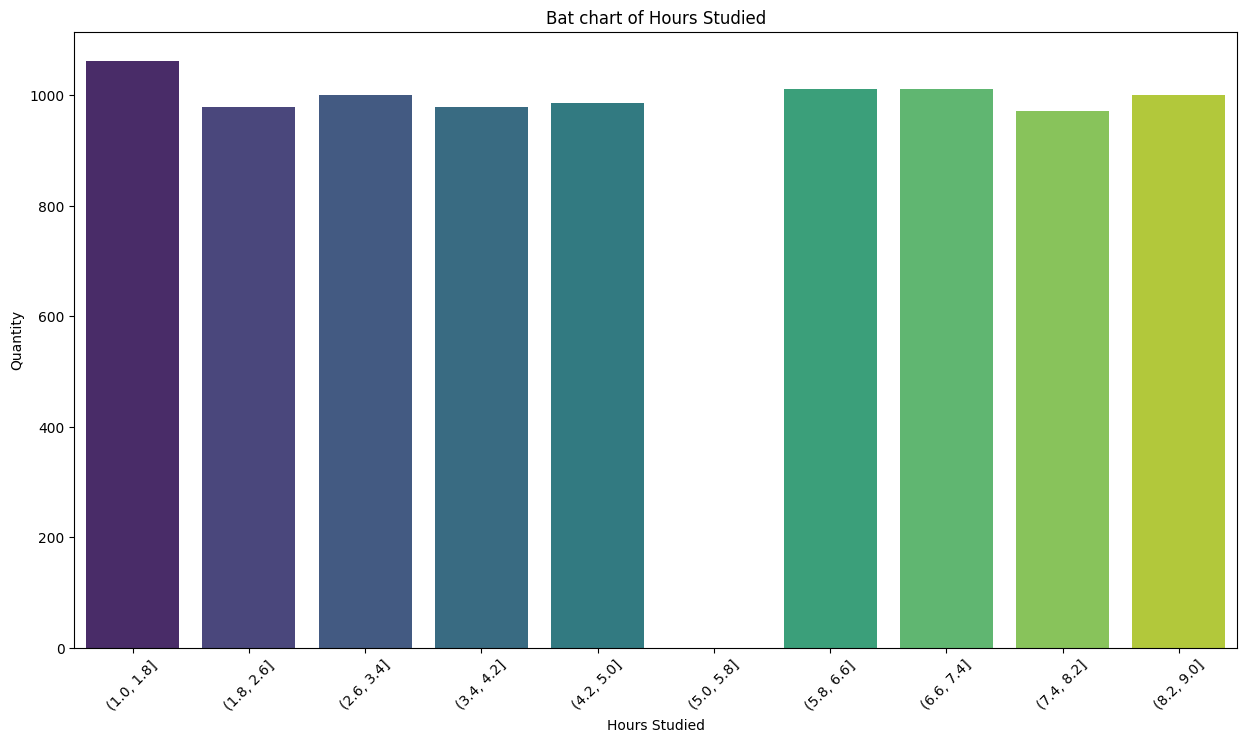

<ipython-input-3-19f9c966e87e>:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby('feature_binned').size().reset_index(name='counts')
<ipython-input-3-19f9c966e87e>:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='feature_binned', y='counts', data=counts, palette='viridis')


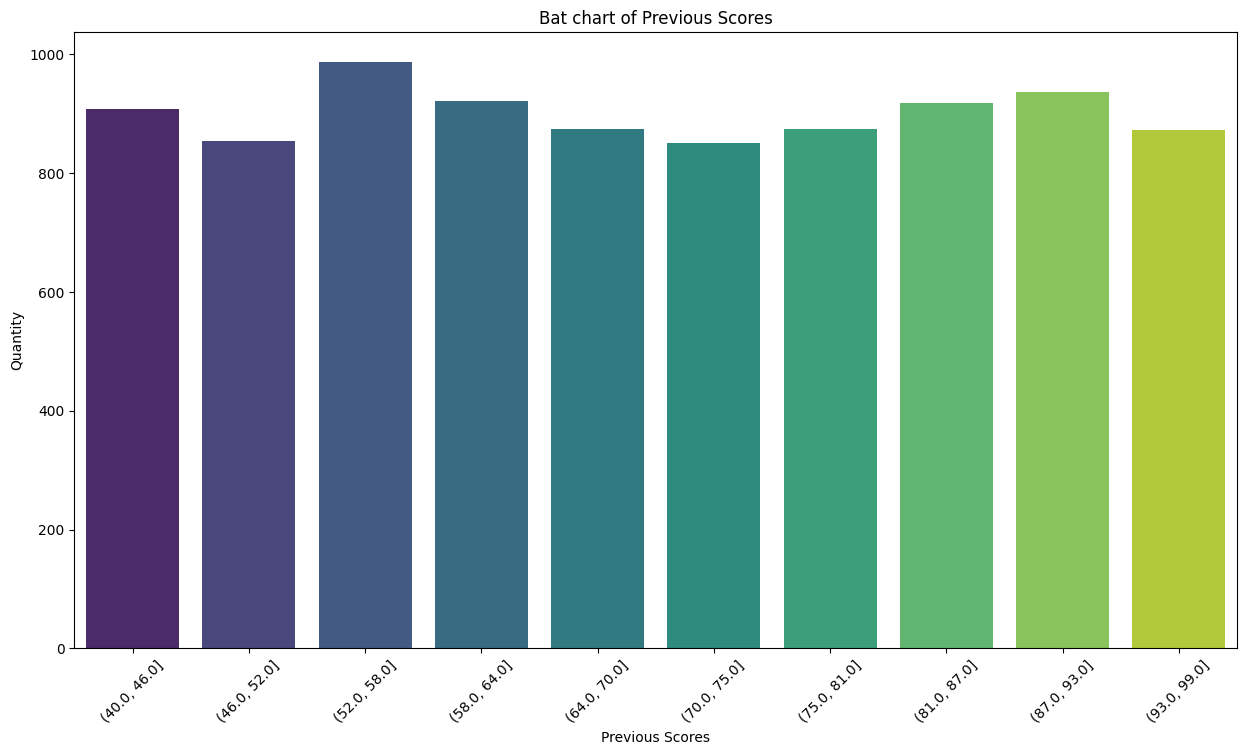

<ipython-input-3-19f9c966e87e>:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby('feature_binned').size().reset_index(name='counts')
<ipython-input-3-19f9c966e87e>:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='feature_binned', y='counts', data=counts, palette='viridis')


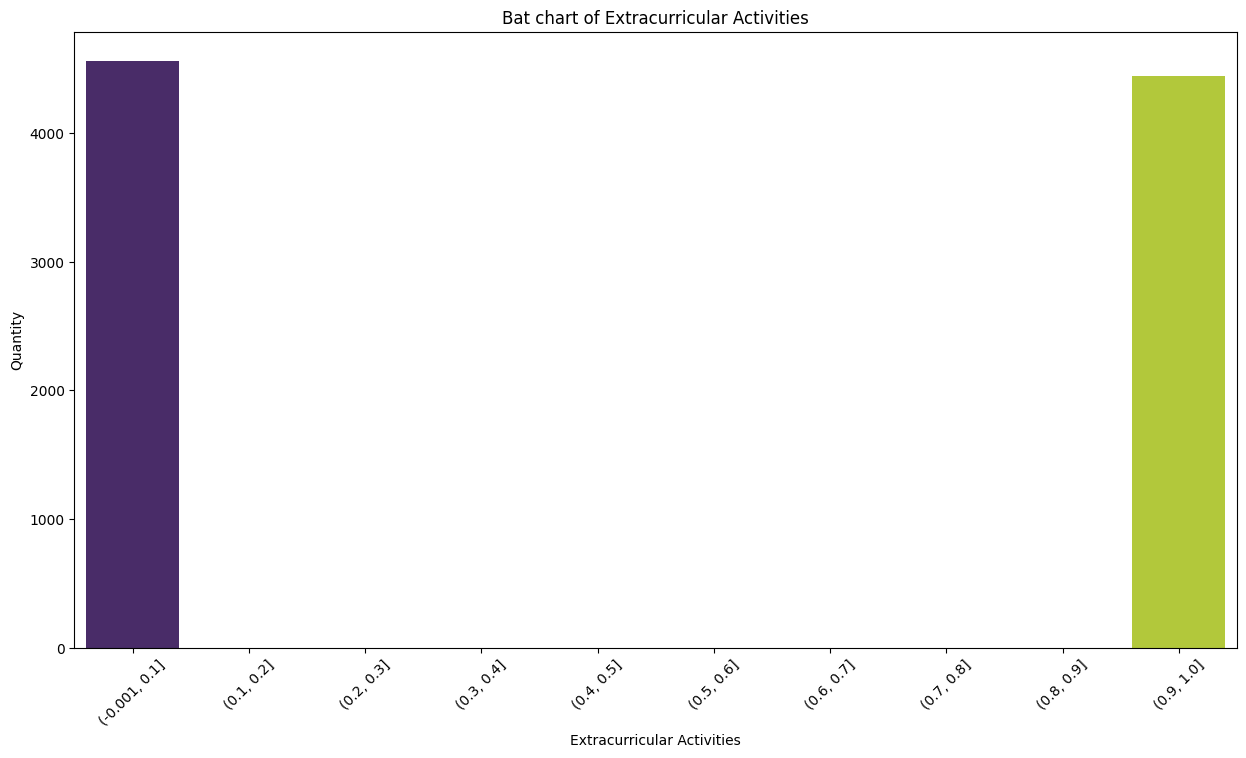

<ipython-input-3-19f9c966e87e>:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby('feature_binned').size().reset_index(name='counts')
<ipython-input-3-19f9c966e87e>:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='feature_binned', y='counts', data=counts, palette='viridis')


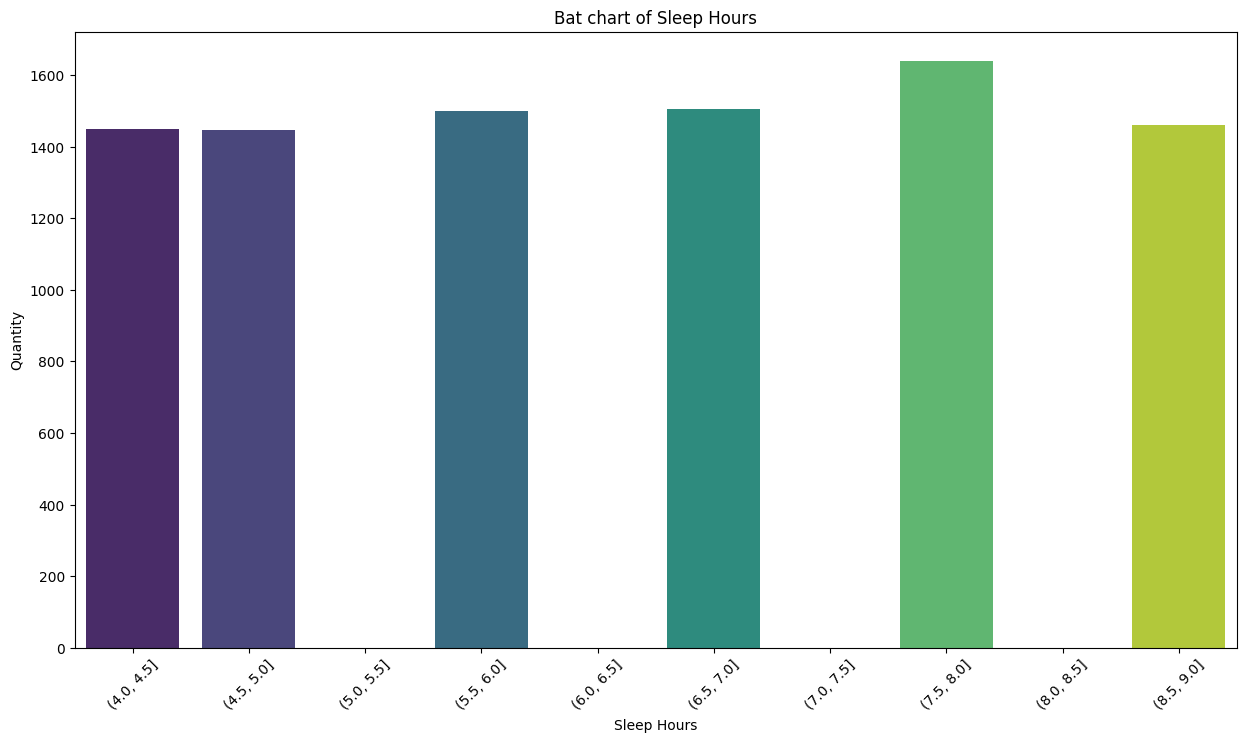

<ipython-input-3-19f9c966e87e>:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby('feature_binned').size().reset_index(name='counts')
<ipython-input-3-19f9c966e87e>:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='feature_binned', y='counts', data=counts, palette='viridis')


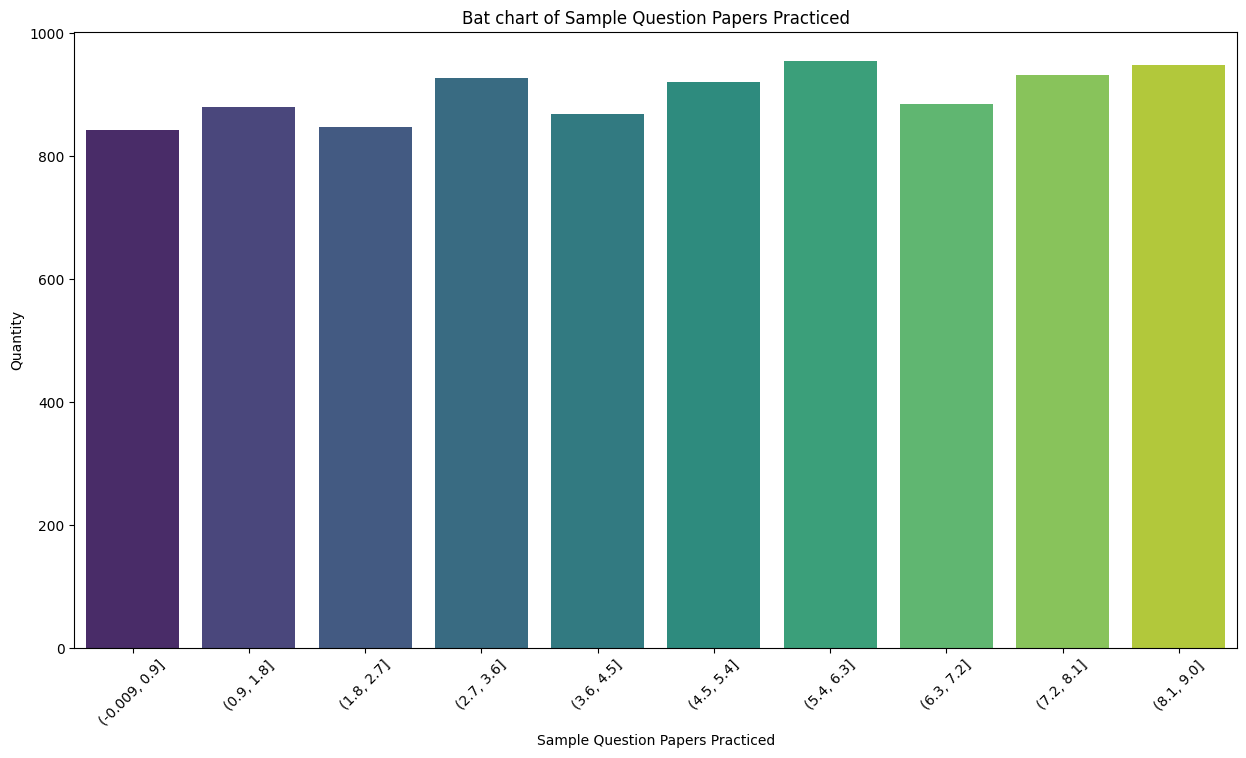

Hours Studied  Previous Scores  Extracurricular Activities  \
count       9000.000000      9000.000000                 9000.000000   
mean           4.976444        69.396111                    0.493667   
std            2.594647        17.369957                    0.499988   
min            1.000000        40.000000                    0.000000   
25%            3.000000        54.000000                    0.000000   
50%            5.000000        69.000000                    0.000000   
75%            7.000000        85.000000                    1.000000   
max            9.000000        99.000000                    1.000000   
range          8.000000        59.000000                    1.000000   
IQR            4.000000        31.000000                    1.000000   
variance       6.732193       301.715398                    0.249988   

          Sleep Hours  Sample Question Papers Practiced  Performance Index  
count     9000.000000                       9000.000000        9000.000000  
mean         6.535556                          4.590889          55.136333  
std          1.695533                          2.864570          19.187669  
min          4.000000                          0.000000          10.000000  
25%          5.000000                          2.000000          40.000000  
50%          7.000000                          5.000000          55.000000  
75%          8.000000                          7.000000          70.000000  
max          9.000000                          9.000000         100.000000  
range        5.000000                          9.000000          90.000000  
IQR          3.000000                          5.000000          30.000000  
variance     2.874833                          8.205762         368.166654

In [4]:
# Phân tích khám phá dữ liệu thông qua thống kê và các biểu đồ
# Chỉ được phân tích trên tập huấn luyện
for f in features:
    plot_bar_chart(X_train[f], y_train, f'Bat chart of {f}')

describe_data_statistic(train)

# Yêu cầu 2a: Xây dựng mô hình sử dụng toàn bộ 5 đặc trưng đề bài cung cấp (2 điểm)

In [5]:
# Phần code cho yêu cầu 2a

# Training
x_train_pre = preprocess(X_train)
model_a = OLSLinearRegression()
model_a.fit(x_train_pre, y_train)
wa = model_a.get_params()
print_formula(wa, features)


# Testing
X_test_pre = preprocess(X_test)
y_test_predicted = model_a.predict(X_test_pre)

Student Performance = -33.969 * 1 + 2.852 * Hours Studied + 1.018 * Previous Scores + 0.604 * Extracurricular Activities + 0.474 * Sleep Hours + 0.192 * Sample Question Papers Practiced


In [6]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
MAE_a = mae(y_test_predicted, y_test)
MAE_a

1.595648688476289

Công thức hồi quy, phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = ...$$

# Yêu cầu 2b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng, tìm mô hình cho kết quả tốt nhất (2 điểm)

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [7]:
# Phần code cho yêu cầu 2b
# Tìm ra đặc trưng tốt nhất (trong 5 đặc trưng)
# In ra các kết quả cross-validation như yêu cầu
x_shuffled_train, y_shuffled_train = shuffle_data(X_train, y_train)

mae_list_b = cross_validate_features(x_shuffled_train, y_shuffled_train, features)
best_feature = find_best_feature(mae_list_b)

print(f'Đặc trưng tốt nhất: {best_feature}')
print('Kết quả MAE (trung bình):')
for feature in features:
    print(f'- {feature}: {mae_list_b[feature]:.4f}')


Đặc trưng tốt nhất: Previous Scores
Kết quả MAE (trung bình):
- Hours Studied: 15.4515
- Previous Scores: 6.6189
- Extracurricular Activities: 16.1964
- Sleep Hours: 16.1903
- Sample Question Papers Practiced: 16.1876


In [8]:
# Huấn luyện lại mô hình best_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
model_b = train_best_feature(X_train, y_train, best_feature)
wb = model_b.get_params()

In [9]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_feature_model
mae_b = evaluate_best_feature_model(model_b, X_test, y_test, best_feature)
print_formula(wb, [best_feature])
print(f'MAE trên tập test của đặc trưng tốt nhất {best_feature}: {mae_b:.4f}')

Student Performance = -14.989 * 1 + 1.011 * Previous Scores
MAE trên tập test của đặc trưng tốt nhất Previous Scores: 6.5443


Công thức hồi quy (dựa trên mô hình đặc trưng tốt nhất), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = ...$$

# Yêu cầu 2c: Sinh viên tự xây dựng/thiết kế mô hình, tìm mô hình cho kết quả tốt nhất (2 điểm)

## Xây dựng/Thiết kế mô hình

In [10]:
# Trình bày toàn bộ code liên quan đến việc thiết kế mô hình
combined_feature_list = ['Hours Studied', 'Previous Scores']
combined_feature, mae_list_c1 = train_model_with_combined_features(x_shuffled_train, y_shuffled_train, combined_feature_list)
x_squared_train, mae_list_c2 = train_model_square_features(x_shuffled_train, y_shuffled_train)
x_cube_train, mae_list_c3 = train_model_cube_features(x_shuffled_train, y_shuffled_train)

## Tìm mô hình cho kết quả tốt nhất

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

In [11]:
# Phần code cho yêu cầu 2c
# Tìm ra mô hình tốt nhất (trong m mô hình mà sinh viên tự thiết kế)
# In ra các kết quả cross-validation như yêu cầu
best_combined_feature = find_best_feature(mae_list_c1)
best_square_feature = find_best_feature(mae_list_c2)
best_cube_feature = find_best_feature(mae_list_c3)


print('Đặc trưng kết hợp')
for f in mae_list_c1:
    print(f'- {f}: {mae_list_c1[f]:.4f}')
print(f'==> Đặc trưng kết hợp tốt nhất của {combined_feature_list}: {best_combined_feature}\n')

print('Đặc trưng bình phương')
for f in mae_list_c2:
    print(f'- {f}: {mae_list_c2[f]:.4f}')
print(f'==> Đặc trưng bình phương tốt nhất: {best_square_feature}\n')

print('Đặc trưng lập phương')
for f in mae_list_c3:
    print(f'- {f}: {mae_list_c3[f]:.4f}')
print(f'==> Đặc trưng lập phương tốt nhất: {best_cube_feature}\n')


# Tìm mô hình tốt nhất
mae_values = {
    'combined': mae_list_c1[best_combined_feature],
    'squared': mae_list_c2[best_square_feature],
    'cubed': mae_list_c3[best_cube_feature]
}

best_model_name = min(mae_values, key=mae_values.get)
print(f'\nMô hình tốt nhất: {best_model_name} model')

Đặc trưng kết hợp
- Sum_Feature: 4.4041
- Multiple_Feature: 11.0848
==> Đặc trưng kết hợp tốt nhất của ['Hours Studied', 'Previous Scores']: Sum_Feature

Đặc trưng bình phương
- Hours Studied: 15.5086
- Previous Scores: 6.7674
- Extracurricular Activities: 16.1964
- Sleep Hours: 16.1907
- Sample Question Papers Practiced: 16.1884
==> Đặc trưng bình phương tốt nhất: Previous Scores

Đặc trưng lập phương
- Hours Studied: 15.5897
- Previous Scores: 7.1448
- Extracurricular Activities: 16.1964
- Sleep Hours: 16.1911
- Sample Question Papers Practiced: 16.1895
==> Đặc trưng lập phương tốt nhất: Previous Scores


Mô hình tốt nhất: combined model


In [12]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện
x_combined_train = get_combined_data(X_train, combined_feature_list)
best_model = train_best_feature(x_combined_train, y_train, best_combined_feature)

In [13]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình my_best_model
x_combined_test = get_combined_data(X_test, combined_feature_list)
evaluate_best_feature_model(best_model, x_combined_test, y_test, best_combined_feature)

print_formula(best_model.get_params(), [best_combined_feature])


Student Performance = -23.231 * 1 + 1.054 * Sum_Feature


Công thức hồi quy (dựa trên mô hình tốt nhất mà sinh viên tự xây dựng/thiết kế), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = ...$$